In [1]:
import torch
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

import torch.nn as nn
import torch.nn.functional as F

from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

#### B-VAE:

In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.c1 = nn.Conv2d(3, 64, 3, 2, padding=1)   # 64 -> 32
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.LeakyReLU()
        self.c2 = nn.Conv2d(64, 128, 3, 2, padding=1) # 32 -> 16
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.LeakyReLU()
        self.c3 = nn.Conv2d(128, 128, 3, 2, padding=1) # 16 -> 8
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.LeakyReLU()
        self.c4 = nn.Conv2d(128, 128, 3, 2, padding=1) # 8 -> 4
        self.bn4 = nn.BatchNorm2d(128)
        self.act4 = nn.LeakyReLU()
        self.c5 = nn.Conv2d(128, 128, 3, 2, padding=1) # 4 -> 2
        self.bn5 = nn.BatchNorm2d(128)
        self.act5 = nn.LeakyReLU()
        self.flatten_layer = nn.Flatten(start_dim=1)
        self.z_mu = nn.Linear(128 * 2 * 2, latent_dim)
        self.z_logvar = nn.Linear(128 * 2 * 2, latent_dim)

    def forward(self, x):
        x = self.act1(self.bn1(self.c1(x)))
        x = self.act2(self.bn2(self.c2(x)))
        x = self.act3(self.bn3(self.c3(x)))
        x = self.act4(self.bn4(self.c4(x)))
        x = self.act5(self.bn5(self.c5(x)))
        x = self.flatten_layer(x)
        return self.z_mu(x), self.z_logvar(x)
    
    
class Sampling(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

    def forward(self, z_mean, z_logvar):
        batch_size, _ = z_mean.shape
        epsilon = torch.randn(batch_size, self.latent_dim, device = z_mean.device)
        return z_mean + torch.exp(0.5 * z_logvar) * epsilon
    

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.dense1 = nn.Linear(latent_dim, 128 * 2 * 2)
        self.dbn1 = nn.BatchNorm1d(128 * 2 * 2)
        self.dact1 = nn.LeakyReLU()
        
        self.ct1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)  # 4x4
        self.bn1 = nn.BatchNorm2d(128)
        self.act1 = nn.LeakyReLU()
        
        self.ct2 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)  # 8x8
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.LeakyReLU()
        
        self.ct3 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)  # 16x16
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.LeakyReLU()
        
        self.ct4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)  # 32x32
        self.bn4 = nn.BatchNorm2d(64)
        self.act4 = nn.LeakyReLU()
        
        self.ct5 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1)  # 64x64
        self.act5 = nn.Sigmoid()

    def forward(self, x):
        x = self.dact1(self.dbn1(self.dense1(x)))
        x = x.view(-1, 128, 2, 2)
        x = self.act1(self.bn1(self.ct1(x)))
        x = self.act2(self.bn2(self.ct2(x)))
        x = self.act3(self.bn3(self.ct3(x)))
        x = self.act4(self.bn4(self.ct4(x)))
        x = self.act5(self.ct5(x))
        return x


In [3]:
def KL_Divergence_Loss(z_mean, z_logvar):
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean**2 - torch.exp(z_logvar), dim=1)
    kl_loss = kl_loss.mean()
    return kl_loss

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self,encoder, decoder, sampling_layer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling_layer = sampling_layer

    def forward(self,x):
        z_mean, z_logvar = self.encoder(x)
        loss = KL_Divergence_Loss(z_mean, z_logvar)
        z_sample = self.sampling_layer(z_mean, z_logvar)
        out = self.decoder(z_sample)
        return loss, out

In [5]:
def getDataset(cinic_directory, transform):
    return torchvision.datasets.ImageFolder(
                cinic_directory,
                transform = transform
    )

def getDataLoader(dataset, batch_size, num_workers = 16, pin_memory = True):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers = num_workers,
        pin_memory = pin_memory
    )

In [6]:
def trainEpoch(model, loader, optimizer, loss_fun, beta, device, batch_size):
    model.train()
    total_loss = 0
    total_kl_loss = 0
    total_rec_loss = 0
    num_batches = len(loader)

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        kl_loss, outs = model(inputs)
        outs = outs.to(device)
        
        reconstructed_loss = loss_fun(inputs, outs)
        reconstructed_loss = reconstructed_loss/batch_size

        total_kl_loss += kl_loss.item()
        total_rec_loss += reconstructed_loss.item()

        loss = reconstructed_loss + beta * kl_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_train_loss = total_loss / num_batches
    avg_rec_loss = total_rec_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    return avg_train_loss, avg_rec_loss, avg_kl_loss


def evaluate(model, loader, loss_fun, beta, device, epoch, epochs, optimizer, scheduler, 
             avg_train_loss, avg_rec_loss, avg_kl_loss, val_losses):
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            kl_loss, outs = model(xb)

            rec_loss = loss_fun(outs, xb)
            val_loss = rec_loss + beta * kl_loss

            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Rec Loss: {avg_rec_loss:.4f}, "
          f"KL Loss: {avg_kl_loss:.4f}")

    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    scheduler.step(avg_val_loss)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[LOG]: Device = {device.type}")

transform = transforms.Compose([
    transforms.Resize((64, 64)),             
    transforms.ToTensor(),
])


data_path = "./Data/"
dataset = getDataset(data_path, transform)

indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

trainLoader = getDataLoader(train_dataset, 64)
testLoader = getDataLoader(test_dataset, 64)

# sprawdź jak to wpływa na model zmiana latent_space
latent_dim = 100
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
sampling_layer = Sampling(latent_dim)


model = AutoEncoder(
    encoder=encoder
    ,decoder=decoder
    ,sampling_layer=sampling_layer
    )

model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.01,weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1,threshold=0.001)
criterion = nn.MSELoss(reduction='sum')

# sprawdzić 30, 50 ,100 to szybko idzie
epochs = 30

val_losses = []

# to jest parametr który mówi jak bardzo funkcja celu skupia się na tym żeby latent space była spójn, bez dziur.
beta = 2

# Trening
for epoch in range(epochs):
    avg_train_loss, avg_rec_loss, avg_kl_loss = trainEpoch(
        model=model,
        loader=trainLoader,
        optimizer=optimizer,
        loss_fun=criterion,
        beta=beta,
        device=device,
        batch_size=128
    )

    evaluate(
        model=model,
        loader=testLoader,
        loss_fun=criterion,
        beta=beta,
        device=device,
        epoch=epoch,
        epochs=epochs,
        optimizer=optimizer,
        scheduler=scheduler,
        avg_train_loss=avg_train_loss,
        avg_rec_loss=avg_rec_loss,
        avg_kl_loss=avg_kl_loss,
        val_losses=val_losses
    )

[LOG]: Device = cuda
Epoch 1/30 - Train Loss: 245.5227, Validation Loss: 20695.3204, Rec Loss: 222.0635, KL Loss: 11.7296
Learning Rate: 0.010000
Epoch 2/30 - Train Loss: 178.5991, Validation Loss: 18201.1069, Rec Loss: 151.6446, KL Loss: 13.4772
Learning Rate: 0.010000
Epoch 3/30 - Train Loss: 169.5638, Validation Loss: 17193.2930, Rec Loss: 140.4350, KL Loss: 14.5644
Learning Rate: 0.010000
Epoch 4/30 - Train Loss: 164.8609, Validation Loss: 17230.0908, Rec Loss: 134.2819, KL Loss: 15.2895
Learning Rate: 0.010000
Epoch 5/30 - Train Loss: 160.9405, Validation Loss: 16033.8375, Rec Loss: 128.8560, KL Loss: 16.0423
Learning Rate: 0.010000
Epoch 6/30 - Train Loss: 156.2315, Validation Loss: 15338.3995, Rec Loss: 122.6976, KL Loss: 16.7669
Learning Rate: 0.010000
Epoch 7/30 - Train Loss: 154.7841, Validation Loss: 15308.2692, Rec Loss: 120.7292, KL Loss: 17.0274
Learning Rate: 0.010000
Epoch 8/30 - Train Loss: 152.9662, Validation Loss: 15529.0628, Rec Loss: 118.3970, KL Loss: 17.2846
Lea

In [8]:
import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils

def show_generated_grid(decoder, latent_dim, device, num_images=9, images_per_row=3):
    decoder.eval()
    
    # Wygeneruj latenty
    z_samples = torch.randn(num_images, latent_dim).to(device)

    with torch.no_grad():
        gen_imgs = decoder(z_samples).cpu()
        
    grid = vutils.make_grid(gen_imgs, nrow=images_per_row, normalize=True)
    np_grid = grid.permute(1, 2, 0).numpy()

    # Wyświetl
    plt.figure(figsize=(images_per_row * 2, (num_images // images_per_row) * 2))
    plt.imshow(np_grid)
    plt.axis('off')
    plt.title("Generated images")
    plt.show()


#### Random 9 images of cats:

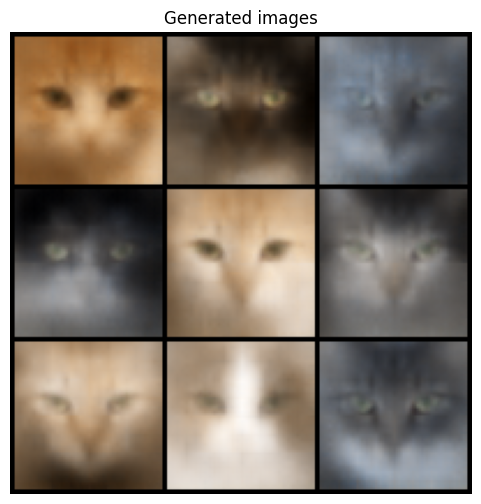

In [9]:
show_generated_grid(decoder=decoder,latent_dim=latent_dim,device=device)

In [10]:
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048).to(device)


num_samples = 700
z_samples = torch.randn(num_samples, latent_dim).to(device)
with torch.no_grad():
    generated_imgs = decoder(z_samples).cpu()
    generated_imgs = (generated_imgs + 1) * 127.5
    generated_imgs = generated_imgs.clamp(0, 255).byte()
    gen_img_resized = F.interpolate(generated_imgs.float(), size=(299, 299), mode='bilinear', align_corners=False).byte()

fid.update(gen_img_resized.to(device), real=False)

real_imgs = []

transform_fid = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

dataset = getDataset(data_path, transform_fid)
loader = getDataLoader(dataset, 256)

for x, _ in loader:
    real_imgs.append((x * 255).clamp(0, 255).byte())
    if sum(t.shape[0] for t in real_imgs) >= num_samples:
        break
real_imgs = torch.cat(real_imgs)[:num_samples]

fid.update(real_imgs.to(device), real=True)
fid_score = fid.compute()
print(f"FID score: {fid_score.item():.4f}")


FID score: 182.7774


#### Interpolation

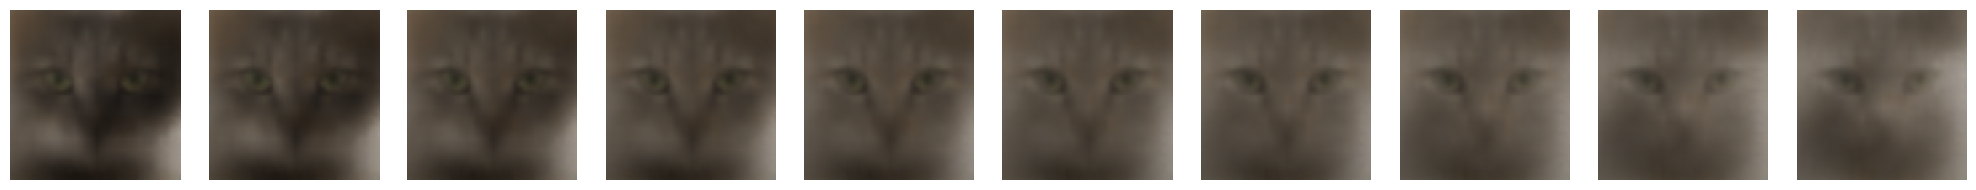

In [11]:
z1 = torch.randn(latent_dim).to(device)
z2 = torch.randn(latent_dim).to(device)

interpolated = []
steps = 10
for alpha in torch.linspace(0, 1, steps):
    z = (1 - alpha) * z1 + alpha * z2
    interpolated.append(z)
interpolated = torch.stack(interpolated)

with torch.no_grad():
    gen_imgs = decoder(interpolated).cpu()

fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    img = gen_imgs[i].numpy().transpose(1, 2, 0)
    axs[i].imshow(img)
    axs[i].axis("off")
plt.tight_layout()
plt.show()

